# Text Classification: Complete Pipeline

## Overview

This notebook demonstrates a complete text classification pipeline from raw text to model evaluation. We cover three types of classification problems using multiple feature engineering techniques and machine learning algorithms.

---

## Table of Contents

1. [Introduction](#introduction)
2. [Setup and Installation](#setup)
3. [Data Cleaning](#cleaning)
4. [Text Preprocessing](#preprocessing)
5. [Feature Engineering Methods](#feature-engineering)
   - 5.1 CountVectorizer (Bag of Words)
   - 5.2 TF-IDF
   - 5.3 BM25
   - 5.4 Word2Vec Embeddings
6. [Classification Tasks](#classification)
   - 6.1 Binary Classification (Email Spam)
   - 6.2 Multiclass Classification (BBC News)
   - 6.3 Multilabel Classification (Toxic Comments)
7. [Results Summary](#summary)
8. [Conclusions](#conclusions)

---

<a id='introduction'></a>
## 1. Introduction

### What is Text Classification?

Text classification is the task of assigning predefined categories to text documents. It's one of the most common NLP tasks with applications including:

- **Spam Detection**: Classifying emails as spam or not spam
- **Sentiment Analysis**: Determining if a review is positive or negative
- **Topic Categorization**: Assigning news articles to categories
- **Content Moderation**: Detecting toxic or inappropriate content

### Types of Classification

| Type | Description | Example | Labels per Document |
|------|-------------|---------|--------------------|
| **Binary** | Two mutually exclusive classes | Spam vs. Ham | Exactly 1 |
| **Multiclass** | 3+ mutually exclusive classes | News categories | Exactly 1 |
| **Multilabel** | Multiple labels can be assigned | Content tags | 0 to many |

### Pipeline Overview

```
Raw Text → Cleaning → Preprocessing → Feature Engineering → Model Training → Evaluation
```

Each step transforms the data to make it suitable for machine learning algorithms.

<a id='setup'></a>
## 2. Setup and Installation

### Required Libraries

| Library | Purpose |
|---------|--------|
| `pandas` | Data manipulation |
| `numpy` | Numerical operations |
| `scikit-learn` | ML algorithms and vectorizers |
| `nltk` | Stopwords and tokenization |
| `rank_bm25` | BM25 scoring |
| `gensim` | Word2Vec embeddings |

In [1]:
# =============================================================================
# INSTALLATION
# =============================================================================
# Uncomment and run if packages are not installed:

# !pip install pandas numpy scikit-learn matplotlib seaborn
# !pip install nltk rank_bm25 gensim sentence-transformers
#!pip install tf-keras

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import nltk
from nltk.corpus import stopwords

# Feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from rank_bm25 import BM25Okapi
import gensim.downloader as api


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    hamming_loss, jaccard_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
import time
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Download NLTK data
nltk.download('stopwords', quiet=True)

print("All libraries imported successfully!")

All libraries imported successfully!


---

<a id='cleaning'></a>
## 3. Data Cleaning

### Why Clean Text?

Raw text data often contains noise that doesn't contribute to classification:
- HTML tags from web scraping
- URLs and email addresses
- Excessive whitespace
- Special characters

Cleaning removes this noise to improve model performance.

### Cleaning Methods Used

| Method | What it does | Example |
|--------|--------------|--------|
| Remove HTML | Strips `<tag>` elements | `<p>Hello</p>` → `Hello` |
| Remove URLs | Removes web links | `Check http://x.com` → `Check` |
| Remove Emails | Removes email addresses | `Contact a@b.com` → `Contact` |
| Normalize Whitespace | Collapses multiple spaces | `Hello    world` → `Hello world` |

In [3]:
# =============================================================================
# DATA CLEANING FUNCTION
# =============================================================================

def clean_text(text):
    """
    Clean raw text by removing noise.
    
    Steps:
        1. Remove HTML tags (e.g., <p>, <div>, <br>)
        2. Remove URLs (http://, https://, www.)
        3. Remove email addresses
        4. Normalize whitespace (multiple spaces → single space)
    
    Parameters:
        text (str): Raw text string
    
    Returns:
        str: Cleaned text string
    
    Example:
        >>> clean_text("<p>Visit http://example.com or email test@mail.com</p>")
        'Visit or email'
    """
    # Handle missing values
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # Step 1: Remove HTML tags
    # Pattern: <anything> where anything doesn't contain >
    text = re.sub(r'<[^>]+>', '', text)
    
    # Step 2: Remove URLs
    # Pattern: http(s):// or www. followed by non-whitespace
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Step 3: Remove email addresses
    # Pattern: something@something.something
    text = re.sub(r'\S+@\S+', '', text)
    
    # Step 4: Normalize whitespace
    # Replace multiple spaces/tabs/newlines with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [4]:
# =============================================================================
# TEST CLEANING FUNCTION
# =============================================================================

# Example with various noise types
test_dirty = """
<html><body>
<p>Hello! Check out http://example.com for more info.</p>
<p>Contact us at support@company.com or visit www.company.com</p>
</body></html>
"""

print("BEFORE CLEANING:")
print("-" * 50)
print(test_dirty)
print("\nAFTER CLEANING:")
print("-" * 50)
print(clean_text(test_dirty))

BEFORE CLEANING:
--------------------------------------------------

<html><body>
<p>Hello! Check out http://example.com for more info.</p>
<p>Contact us at support@company.com or visit www.company.com</p>
</body></html>


AFTER CLEANING:
--------------------------------------------------
Hello! Check out for more info. Contact us at or visit


---

<a id='preprocessing'></a>
## 4. Text Preprocessing

### Why Preprocess?

After cleaning, we standardize the text to reduce vocabulary size and focus on meaningful words.

### Preprocessing Methods Used

| Method | What it does | Example |
|--------|--------------|--------|
| Lowercasing | Converts to lowercase | `Hello WORLD` → `hello world` |
| Stopword Removal | Removes common words | `the cat is here` → `cat here` |

### What are Stopwords?

Stopwords are common words that appear frequently but carry little meaning:
- Articles: the, a, an
- Prepositions: in, on, at, to
- Conjunctions: and, but, or
- Pronouns: he, she, it, they

Removing them reduces noise and feature dimensionality.

In [5]:
# =============================================================================
# TEXT PREPROCESSING FUNCTION
# =============================================================================

# Load English stopwords once
STOP_WORDS = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess cleaned text for feature extraction.
    
    Steps:
        1. Convert to lowercase
        2. Remove stopwords
    
    Parameters:
        text (str): Cleaned text string
    
    Returns:
        str: Preprocessed text string
    
    Example:
        >>> preprocess_text("The Quick Brown Fox Jumps Over The Lazy Dog")
        'quick brown fox jumps lazy dog'
    """
    # Step 1: Convert to lowercase
    text = text.lower()
    
    # Step 2: Tokenize and remove stopwords
    tokens = text.split()
    tokens = [token for token in tokens if token not in STOP_WORDS]
    
    return ' '.join(tokens)


def full_preprocess(text):
    """
    Apply full preprocessing pipeline: cleaning + preprocessing.
    
    Parameters:
        text (str): Raw text string
    
    Returns:
        str: Fully preprocessed text string
    """
    return preprocess_text(clean_text(text))

In [6]:
# =============================================================================
# TEST PREPROCESSING FUNCTION
# =============================================================================

test_text = "The Quick Brown Fox Jumps Over The Lazy Dog"

print("BEFORE PREPROCESSING:")
print(f"  '{test_text}'")
print(f"  Word count: {len(test_text.split())}")

print("\nAFTER PREPROCESSING:")
processed = preprocess_text(test_text)
print(f"  '{processed}'")
print(f"  Word count: {len(processed.split())}")

print("\nSTOPWORDS REMOVED:")
removed = set(test_text.lower().split()) - set(processed.split())
print(f"  {removed}")

BEFORE PREPROCESSING:
  'The Quick Brown Fox Jumps Over The Lazy Dog'
  Word count: 9

AFTER PREPROCESSING:
  'quick brown fox jumps lazy dog'
  Word count: 6

STOPWORDS REMOVED:
  {'over', 'the'}


---

<a id='feature-engineering'></a>
## 5. Feature Engineering Methods

### Why Feature Engineering?

Machine learning algorithms require numerical input. Feature engineering converts text into numerical vectors (arrays of numbers).

### Overview of Methods

| Method | Type | Vector Size | Captures Semantics? | Speed |
|--------|------|-------------|---------------------|-------|
| CountVectorizer | Sparse | Vocabulary size | No | Fast |
| TF-IDF | Sparse | Vocabulary size | No | Fast |
| BM25 | Dense | Corpus size | No | Medium |
| Word2Vec | Dense | 300 | Yes (word-level) | Medium |

### Sparse vs Dense Vectors

- **Sparse**: Most values are zero (bag-of-words methods)
- **Dense**: Most values are non-zero (embedding methods)

### 5.1 CountVectorizer (Bag of Words)

#### How it Works

CountVectorizer converts text into a matrix of word counts:

1. Build vocabulary from all documents
2. For each document, count occurrences of each word
3. Result: Document-term matrix

#### Example

```
Documents:
  Doc1: "cat sat mat"
  Doc2: "dog sat mat"

Vocabulary: [cat, dog, mat, sat]

Matrix:
       cat  dog  mat  sat
Doc1:   1    0    1    1
Doc2:   0    1    1    1
```

#### Pros and Cons

| Pros | Cons |
|------|------|
| Simple and interpretable | Ignores word order |
| Fast computation | High dimensionality |
| Works well as baseline | No semantic meaning |

In [7]:
# =============================================================================
# COUNTVECTORIZER FUNCTIONS
# =============================================================================

def create_count_features(train_texts, test_texts, max_features=5000):
    """
    Create bag-of-words features using CountVectorizer.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
        max_features (int): Maximum vocabulary size (default: 5000)
    
    Returns:
        tuple: (X_train, X_test, vectorizer)
            - X_train: Sparse matrix of training features
            - X_test: Sparse matrix of test features
            - vectorizer: Fitted CountVectorizer object
    
    Example:
        >>> X_train, X_test, vec = create_count_features(train, test)
        >>> print(X_train.shape)  # (n_samples, n_features)
    """
    # Initialize vectorizer
    # ngram_range=(1,2) includes unigrams and bigrams
    vectorizer = CountVectorizer(
        max_features=max_features,
        ngram_range=(1, 2)
    )
    
    # Fit on training data, transform both
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    
    print(f"CountVectorizer:")
    print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, vectorizer

### 5.2 TF-IDF (Term Frequency - Inverse Document Frequency)

#### How it Works

TF-IDF weighs words by importance:

- **TF (Term Frequency)**: How often a word appears in a document
- **IDF (Inverse Document Frequency)**: How rare a word is across all documents

```
TF-IDF = TF × IDF

TF = count(word in doc) / total words in doc
IDF = log(total docs / docs containing word)
```

#### Why TF-IDF?

Words that appear frequently in one document but rarely in others get higher scores:
- "Machine learning" in a tech article → High score
- "The" appearing everywhere → Low score

#### Pros and Cons

| Pros | Cons |
|------|------|
| Weighs important words | Still ignores word order |
| Reduces impact of common words | High dimensionality |
| Industry standard baseline | No semantic meaning |

In [8]:
# =============================================================================
# TF-IDF FUNCTIONS
# =============================================================================

def create_tfidf_features(train_texts, test_texts, max_features=5000):
    """
    Create TF-IDF weighted features.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
        max_features (int): Maximum vocabulary size (default: 5000)
    
    Returns:
        tuple: (X_train, X_test, vectorizer)
            - X_train: Sparse matrix of training features
            - X_test: Sparse matrix of test features
            - vectorizer: Fitted TfidfVectorizer object
    
    Example:
        >>> X_train, X_test, vec = create_tfidf_features(train, test)
        >>> print(X_train.shape)  # (n_samples, n_features)
    """
    # Initialize vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2)
    )
    
    # Fit on training data, transform both
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    
    print(f"TF-IDF:")
    print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, vectorizer

### 5.3 BM25 (Best Matching 25)

#### How it Works

BM25 is a ranking function used in information retrieval. It improves on TF-IDF by:

1. **Term frequency saturation**: Diminishing returns for repeated words
2. **Document length normalization**: Longer documents don't get unfair advantage

#### Formula

```
BM25(D, Q) = Σ IDF(qi) × (f(qi, D) × (k1 + 1)) / (f(qi, D) + k1 × (1 - b + b × |D|/avgdl))

Where:
  - k1 = term frequency saturation (typically 1.2-2.0)
  - b = length normalization (typically 0.75)
  - avgdl = average document length
```

#### Usage for Classification

We use each document as a query against the corpus to create document vectors.

#### Pros and Cons

| Pros | Cons |
|------|------|
| Better than raw TF-IDF | Requires tuning k1, b |
| Handles document length | Slower than TF-IDF |
| Industry standard in search | Dense output (corpus-sized) |

In [9]:
# =============================================================================
# BM25 FUNCTIONS
# =============================================================================

def create_bm25_features(train_texts, test_texts):
    """
    Create BM25-based document similarity features.
    
    How it works:
        1. Tokenize all documents
        2. Fit BM25 on training corpus
        3. For each document, compute BM25 scores against training corpus
        4. Result: Each document represented by its similarity to training docs
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
    
    Returns:
        tuple: (X_train, X_test, bm25_model)
            - X_train: Dense array of training features (n_train, n_train)
            - X_test: Dense array of test features (n_test, n_train)
            - bm25_model: Fitted BM25Okapi object
    
    Example:
        >>> X_train, X_test, bm25 = create_bm25_features(train, test)
        >>> print(X_train.shape)  # (n_train, n_train)
    """
    # Tokenize documents (BM25 expects list of token lists)
    train_tokenized = [doc.split() for doc in train_texts]
    test_tokenized = [doc.split() for doc in test_texts]
    
    # Fit BM25 on training corpus
    bm25_model = BM25Okapi(train_tokenized)
    
    # Create feature vectors
    # Each document gets scores against all training documents
    X_train = np.array([bm25_model.get_scores(doc) for doc in train_tokenized])
    X_test = np.array([bm25_model.get_scores(doc) for doc in test_tokenized])
    
    print(f"BM25:")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test, bm25_model

### 5.4 Word2Vec Embeddings

#### How it Works

Word2Vec learns dense vector representations of words from large text corpora:

1. Words with similar meanings have similar vectors
2. Vector arithmetic captures relationships: king - man + woman ≈ queen
3. For documents, we average word vectors

#### Pre-trained Model

We use Google's pre-trained Word2Vec model:
- Trained on Google News (~100 billion words)
- 3 million words and phrases
- 300-dimensional vectors

#### Pros and Cons

| Pros | Cons |
|------|------|
| Captures word semantics | Averaging loses word order |
| Dense, fixed-size vectors | No OOV (out-of-vocabulary) handling |
| Transfer learning from large corpus | Large model download (~1.6GB) |

In [10]:
# =============================================================================
# WORD2VEC FUNCTIONS
# =============================================================================

# Global variable to store loaded model (load once, use many times)
WORD2VEC_MODEL = None

def load_word2vec_model():
    """
    Load pre-trained Word2Vec model.
    
    Downloads Google News Word2Vec model on first call (~1.6GB).
    Subsequent calls return cached model.
    
    Returns:
        gensim.models.KeyedVectors: Pre-trained Word2Vec model
    """
    global WORD2VEC_MODEL
    if WORD2VEC_MODEL is None:
        print("Loading Word2Vec model (this may take a few minutes on first run)...")
        WORD2VEC_MODEL = api.load('word2vec-google-news-300')
        print(f"Loaded! Vocabulary size: {len(WORD2VEC_MODEL)}")
    return WORD2VEC_MODEL


def get_document_vector(text, model):
    """
    Convert document to vector by averaging word vectors.
    
    Parameters:
        text (str): Document text
        model: Word2Vec model
    
    Returns:
        numpy.ndarray: 300-dimensional document vector
    """
    words = text.split()
    
    # Get vectors for words that exist in vocabulary
    vectors = [model[word] for word in words if word in model]
    
    # Return average, or zeros if no words found
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)


def create_word2vec_features(train_texts, test_texts):
    """
    Create Word2Vec document embeddings.
    
    Parameters:
        train_texts (Series/list): Training text documents
        test_texts (Series/list): Test text documents
    
    Returns:
        tuple: (X_train, X_test)
            - X_train: Dense array (n_train, 300)
            - X_test: Dense array (n_test, 300)
    
    Example:
        >>> X_train, X_test = create_word2vec_features(train, test)
        >>> print(X_train.shape)  # (n_train, 300)
    """
    # Load model
    model = load_word2vec_model()
    
    # Convert documents to vectors
    X_train = np.array([get_document_vector(doc, model) for doc in train_texts])
    X_test = np.array([get_document_vector(doc, model) for doc in test_texts])
    
    print(f"Word2Vec:")
    print(f"  Train shape: {X_train.shape}")
    print(f"  Test shape: {X_test.shape}")
    
    return X_train, X_test

---

## 6. Evaluation Functions

### Metrics Overview

| Metric | Formula | Best For |
|--------|---------|----------|
| **Accuracy** | Correct / Total | Balanced classes |
| **Precision** | TP / (TP + FP) | When FP is costly (spam filter) |
| **Recall** | TP / (TP + FN) | When FN is costly (disease detection) |
| **F1-Score** | 2 × (P × R) / (P + R) | Balance of P and R |
| **Hamming Loss** | Wrong labels / Total labels | Multilabel |
| **Jaccard Score** | Intersection / Union | Multilabel |

In [11]:
# =============================================================================
# EVALUATION FUNCTIONS
# =============================================================================

def evaluate_binary(y_true, y_pred, pos_label='spam'):
    """
    Evaluate binary classification results.
    
    Parameters:
        y_true: True labels
        y_pred: Predicted labels
        pos_label: Positive class label (default: 'spam')
    
    Returns:
        dict: Dictionary of metrics
    """
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, pos_label=pos_label),
        'Recall': recall_score(y_true, y_pred, pos_label=pos_label),
        'F1': f1_score(y_true, y_pred, pos_label=pos_label)
    }


def evaluate_multiclass(y_true, y_pred):
    """
    Evaluate multiclass classification results.
    
    Uses macro averaging (equal weight to each class).
    
    Parameters:
        y_true: True labels
        y_pred: Predicted labels
    
    Returns:
        dict: Dictionary of metrics
    """
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': f1_score(y_true, y_pred, average='macro')
    }


def evaluate_multilabel(y_true, y_pred):
    """
    Evaluate multilabel classification results.
    
    Parameters:
        y_true: True labels (binary matrix)
        y_pred: Predicted labels (binary matrix)
    
    Returns:
        dict: Dictionary of metrics
    """
    return {
        'Hamming Loss': hamming_loss(y_true, y_pred),
        'Jaccard': jaccard_score(y_true, y_pred, average='samples'),
        'Precision': precision_score(y_true, y_pred, average='micro'),
        'Recall': recall_score(y_true, y_pred, average='micro'),
        'F1': f1_score(y_true, y_pred, average='micro')
    }

---

<a id='classification'></a>
## 6. Classification Tasks

Now we apply all feature engineering methods to three classification problems.

### 6.1 Binary Classification: Email Spam Detection

**Task**: Classify emails as `ham` (legitimate) or `spam`

**Dataset**: Email classification dataset with labeled examples

In [12]:
# =============================================================================
# LOAD AND PREPARE EMAIL DATA
# =============================================================================

# Load dataset
email_df = pd.read_csv('Data/email_classification.csv')

print("=" * 60)
print("EMAIL SPAM DATASET")
print("=" * 60)
print(f"Shape: {email_df.shape}")
print(f"\nClass distribution:")
print(email_df['label'].value_counts())
print(f"\nSample rows:")
display(email_df.head())

EMAIL SPAM DATASET
Shape: (179, 2)

Class distribution:
label
ham     100
spam     79
Name: count, dtype: int64

Sample rows:


,email,label
0,Upgrade to our premium plan for exclusive access to premium content and features.,ham
1,Happy holidays from our team! Wishing you joy and prosperity this season.,ham
2,We're hiring! Check out our career opportunities and join our dynamic team.,ham
3,Your Amazon account has been locked. Click here to verify your account information.,spam
4,Your opinion matters! Take our survey and help us enhance your experience.,ham


In [13]:
# =============================================================================
# PREPROCESS EMAIL DATA
# =============================================================================

# Apply full preprocessing pipeline
email_df['text_clean'] = email_df['email'].apply(full_preprocess)

# Show example
print("PREPROCESSING EXAMPLE:")
print("-" * 60)
print("ORIGINAL:")
print(email_df['email'].iloc[0][:300])
print("\nCLEANED:")
print(email_df['text_clean'].iloc[0][:300])

PREPROCESSING EXAMPLE:
------------------------------------------------------------
ORIGINAL:
Upgrade to our premium plan for exclusive access to premium content and features.

CLEANED:
upgrade premium plan exclusive access premium content features.


In [14]:
# =============================================================================
# TRAIN-TEST SPLIT
# =============================================================================

X_train_email, X_test_email, y_train_email, y_test_email = train_test_split(
    email_df['text_clean'],
    email_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=email_df['label']  # Maintain class ratio
)

print(f"Training samples: {len(X_train_email)}")
print(f"Test samples: {len(X_test_email)}")

Training samples: 143
Test samples: 36


In [15]:
# =============================================================================
# BINARY CLASSIFICATION WITH COUNTVECTORIZER
# =============================================================================

print("\n" + "=" * 60)
print("FEATURE: CountVectorizer")
print("=" * 60)

# Create features
X_train_count, X_test_count, _ = create_count_features(X_train_email, X_test_email)

# Store results
binary_count_results = []

# Naive Bayes
print("\nTraining Naive Bayes...")
nb = MultinomialNB()
start_time = time.time()
nb.fit(X_train_count, y_train_email)
y_pred = nb.predict(X_test_count)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Naive Bayes'
binary_count_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
start_time = time.time()
lr.fit(X_train_count, y_train_email)
y_pred = lr.predict(X_test_count)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Logistic Regression'
binary_count_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# SVM
print("Training SVM...")
svm = LinearSVC(random_state=42, max_iter=2000)
start_time = time.time()
svm.fit(X_train_count, y_train_email)
y_pred = svm.predict(X_test_count)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'SVM'
binary_count_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf.fit(X_train_count, y_train_email)
y_pred = rf.predict(X_test_count)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Random Forest'
binary_count_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Display results
df_count = pd.DataFrame(binary_count_results)
df_count['Feature'] = 'CountVectorizer'
print("\nResults:")
display(df_count.set_index('Algorithm').style.format('{:.2%}', subset=['Accuracy', 'Precision', 'Recall', 'F1']))


FEATURE: CountVectorizer
CountVectorizer:
  Vocabulary size: 1024
  Train shape: (143, 1024)
  Test shape: (36, 1024)

Training Naive Bayes...
  F1: 0.9143 | Time: 0.0165s
              precision    recall  f1-score   support

         ham       1.00      0.85      0.92        20
        spam       0.84      1.00      0.91        16

    accuracy                           0.92        36
   macro avg       0.92      0.93      0.92        36
weighted avg       0.93      0.92      0.92        36

Training Logistic Regression...
  F1: 0.9677 | Time: 0.0221s
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98        20
        spam       1.00      0.94      0.97        16

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

Training SVM...
  F1: 0.9677 | Time: 0.0020s
              precision    recall  f1-score   support

         ham

,Accuracy,Precision,Recall,F1,Train+Predict (s),Feature
Algorithm,,,,,,
Naive Bayes,91.67%,84.21%,100.00%,91.43%,0.016500,CountVectorizer
Logistic Regression,97.22%,100.00%,93.75%,96.77%,0.022100,CountVectorizer
SVM,97.22%,100.00%,93.75%,96.77%,0.002000,CountVectorizer
Random Forest,97.22%,100.00%,93.75%,96.77%,0.138800,CountVectorizer


In [16]:
# =============================================================================
# BINARY CLASSIFICATION WITH TF-IDF
# =============================================================================

print("\n" + "=" * 60)
print("FEATURE: TF-IDF")
print("=" * 60)

# Create features
X_train_tfidf, X_test_tfidf, _ = create_tfidf_features(X_train_email, X_test_email)

# Store results
binary_tfidf_results = []

# Naive Bayes
print("\nTraining Naive Bayes...")
nb = MultinomialNB()
start_time = time.time()
nb.fit(X_train_tfidf, y_train_email)
y_pred = nb.predict(X_test_tfidf)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Naive Bayes'
binary_tfidf_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
start_time = time.time()
lr.fit(X_train_tfidf, y_train_email)
y_pred = lr.predict(X_test_tfidf)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Logistic Regression'
binary_tfidf_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# SVM
print("Training SVM...")
svm = LinearSVC(random_state=42, max_iter=2000)
start_time = time.time()
svm.fit(X_train_tfidf, y_train_email)
y_pred = svm.predict(X_test_tfidf)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'SVM'
binary_tfidf_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf.fit(X_train_tfidf, y_train_email)
y_pred = rf.predict(X_test_tfidf)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Random Forest'
binary_tfidf_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Display results
df_tfidf = pd.DataFrame(binary_tfidf_results)
df_tfidf['Feature'] = 'TF-IDF'
print("\nResults:")
display(df_tfidf.set_index('Algorithm').style.format('{:.2%}', subset=['Accuracy', 'Precision', 'Recall', 'F1']))


FEATURE: TF-IDF
TF-IDF:
  Vocabulary size: 1024
  Train shape: (143, 1024)
  Test shape: (36, 1024)

Training Naive Bayes...
  F1: 0.9697 | Time: 0.0000s
              precision    recall  f1-score   support

         ham       1.00      0.95      0.97        20
        spam       0.94      1.00      0.97        16

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

Training Logistic Regression...
  F1: 0.9677 | Time: 0.0000s
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98        20
        spam       1.00      0.94      0.97        16

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

Training SVM...
  F1: 0.9375 | Time: 0.0000s
              precision    recall  f1-score   support

         ham       0.95      0

,Accuracy,Precision,Recall,F1,Train+Predict (s),Feature
Algorithm,,,,,,
Naive Bayes,97.22%,94.12%,100.00%,96.97%,0.000000,TF-IDF
Logistic Regression,97.22%,100.00%,93.75%,96.77%,0.000000,TF-IDF
SVM,94.44%,93.75%,93.75%,93.75%,0.000000,TF-IDF
Random Forest,94.44%,93.75%,93.75%,93.75%,0.127700,TF-IDF


In [17]:
# =============================================================================
# BINARY CLASSIFICATION WITH BM25
# =============================================================================

print("\n" + "=" * 60)
print("FEATURE: BM25")
print("=" * 60)

# Create features
X_train_bm25, X_test_bm25, _ = create_bm25_features(X_train_email, X_test_email)

# Store results
binary_bm25_results = []

# Naive Bayes (use GaussianNB for dense features with potential negative values)
print("\nTraining Naive Bayes...")
nb = GaussianNB()
start_time = time.time()
nb.fit(X_train_bm25, y_train_email)
y_pred = nb.predict(X_test_bm25)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Naive Bayes'
binary_bm25_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
start_time = time.time()
lr.fit(X_train_bm25, y_train_email)
y_pred = lr.predict(X_test_bm25)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Logistic Regression'
binary_bm25_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# SVM
print("Training SVM...")
svm = SVC(kernel='linear', random_state=42)
start_time = time.time()
svm.fit(X_train_bm25, y_train_email)
y_pred = svm.predict(X_test_bm25)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'SVM'
binary_bm25_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf.fit(X_train_bm25, y_train_email)
y_pred = rf.predict(X_test_bm25)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Random Forest'
binary_bm25_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Display results
df_bm25 = pd.DataFrame(binary_bm25_results)
df_bm25['Feature'] = 'BM25'
print("\nResults:")
display(df_bm25.set_index('Algorithm').style.format('{:.2%}', subset=['Accuracy', 'Precision', 'Recall', 'F1']))


FEATURE: BM25
BM25:
  Train shape: (143, 143)
  Test shape: (36, 143)

Training Naive Bayes...
  F1: 0.9091 | Time: 0.0020s
              precision    recall  f1-score   support

         ham       0.95      0.90      0.92        20
        spam       0.88      0.94      0.91        16

    accuracy                           0.92        36
   macro avg       0.91      0.92      0.92        36
weighted avg       0.92      0.92      0.92        36

Training Logistic Regression...
  F1: 0.9375 | Time: 0.0085s
              precision    recall  f1-score   support

         ham       0.95      0.95      0.95        20
        spam       0.94      0.94      0.94        16

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36

Training SVM...
  F1: 0.9375 | Time: 0.0000s
              precision    recall  f1-score   support

         ham       0.95      0.95      0.95        20
      

,Accuracy,Precision,Recall,F1,Train+Predict (s),Feature
Algorithm,,,,,,
Naive Bayes,91.67%,88.24%,93.75%,90.91%,0.002000,BM25
Logistic Regression,94.44%,93.75%,93.75%,93.75%,0.008500,BM25
SVM,94.44%,93.75%,93.75%,93.75%,0.000000,BM25
Random Forest,97.22%,100.00%,93.75%,96.77%,0.136600,BM25


In [20]:
# Download the pre-trained Google News Word2Vec model if not present
#first download and save

import gensim.downloader as api
w2v = api.load("word2vec-google-news-300")


In [21]:
def get_word2vec_features(texts, model=w2v):
    """
    Convert texts to document vectors by averaging word vectors.
    Each document becomes a 300-dim vector.
    """
    features = []
    for text in texts:
        words = text.lower().split()
        # Collect vectors for words that exist in the model
        word_vecs = [model[word] for word in words if word in model]
        
        if len(word_vecs) > 0:
            features.append(np.mean(word_vecs, axis=0))  # average pooling
        else:
            features.append(np.zeros(model.vector_size))  # fallback: zero vector
    
    return np.array(features)

In [22]:
#convert to Word2vec vectors
X_train_w2v = get_word2vec_features(X_train_email)
X_test_w2v  = get_word2vec_features(X_test_email)

print(X_train_w2v.shape)  # (n_samples, 300)

(143, 300)


In [23]:
# =============================================================================
# BINARY CLASSIFICATION WITH WORD2VEC
# =============================================================================

# Store results
binary_w2v_results = []

# Naive Bayes
print("\nTraining Naive Bayes...")
nb = GaussianNB()
start_time = time.time()
nb.fit(X_train_w2v, y_train_email)
y_pred = nb.predict(X_test_w2v)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Naive Bayes'
binary_w2v_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
start_time = time.time()
lr.fit(X_train_w2v, y_train_email)
y_pred = lr.predict(X_test_w2v)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Logistic Regression'
binary_w2v_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# SVM
print("Training SVM...")
svm = SVC(kernel='linear', random_state=42)
start_time = time.time()
svm.fit(X_train_w2v, y_train_email)
y_pred = svm.predict(X_test_w2v)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'SVM'
binary_w2v_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
start_time = time.time()
rf.fit(X_train_w2v, y_train_email)
y_pred = rf.predict(X_test_w2v)
elapsed = time.time() - start_time
metrics = evaluate_binary(y_test_email, y_pred)
metrics['Train+Predict (s)'] = round(elapsed, 4)
metrics['Algorithm'] = 'Random Forest'
binary_w2v_results.append(metrics)
print(f"  F1: {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
print(classification_report(y_test_email, y_pred))

# Display results
df_w2v = pd.DataFrame(binary_w2v_results)
df_w2v['Feature'] = 'Word2Vec'
print("\nResults:")
display(df_w2v.set_index('Algorithm').style.format('{:.2%}', subset=['Accuracy', 'Precision', 'Recall', 'F1']))


Training Naive Bayes...
  F1: 0.9375 | Time: 0.0074s
              precision    recall  f1-score   support

         ham       0.95      0.95      0.95        20
        spam       0.94      0.94      0.94        16

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36

Training Logistic Regression...
  F1: 0.9375 | Time: 0.0091s
              precision    recall  f1-score   support

         ham       0.95      0.95      0.95        20
        spam       0.94      0.94      0.94        16

    accuracy                           0.94        36
   macro avg       0.94      0.94      0.94        36
weighted avg       0.94      0.94      0.94        36

Training SVM...
  F1: 0.9677 | Time: 0.0000s
              precision    recall  f1-score   support

         ham       0.95      1.00      0.98        20
        spam       1.00      0.94      0.97        16

    accuracy          

,Accuracy,Precision,Recall,F1,Train+Predict (s),Feature
Algorithm,,,,,,
Naive Bayes,94.44%,93.75%,93.75%,93.75%,0.007400,Word2Vec
Logistic Regression,94.44%,93.75%,93.75%,93.75%,0.009100,Word2Vec
SVM,97.22%,100.00%,93.75%,96.77%,0.000000,Word2Vec
Random Forest,94.44%,93.75%,93.75%,93.75%,0.241700,Word2Vec


In [24]:
# =============================================================================
# BINARY CLASSIFICATION SUMMARY
# =============================================================================

# Combine all results
binary_all_results = pd.concat([df_count, df_tfidf, df_bm25, df_w2v], ignore_index=True)

print("\n" + "=" * 70)
print("BINARY CLASSIFICATION: COMPLETE RESULTS")
print("=" * 70)

# Pivot table: F1 Scores
binary_pivot = binary_all_results.pivot(index='Algorithm', columns='Feature', values='F1')
binary_pivot = binary_pivot[['CountVectorizer', 'TF-IDF', 'BM25', 'Word2Vec']]

print("\nF1 Scores by Algorithm and Feature Method:")
display(binary_pivot.style.format('{:.2%}').background_gradient(cmap='YlGn', axis=None))

# Pivot table: Training Time
binary_time_pivot = binary_all_results.pivot(index='Algorithm', columns='Feature', values='Train+Predict (s)')
binary_time_pivot = binary_time_pivot[['CountVectorizer', 'TF-IDF', 'BM25', 'Word2Vec']]

print("\n⏱ Train+Predict Time (seconds) by Algorithm and Feature Method:")
display(binary_time_pivot.style.format('{:.4f}').background_gradient(cmap='YlOrRd', axis=None))

# Best combination
best_idx = binary_all_results['F1'].idxmax()
best = binary_all_results.loc[best_idx]
print(f"\n✓ Best combination: {best['Feature']} + {best['Algorithm']} (F1: {best['F1']:.2%})")

# Fastest combination
fastest_idx = binary_all_results['Train+Predict (s)'].idxmin()
fastest = binary_all_results.loc[fastest_idx]
print(f"⚡ Fastest combination: {fastest['Feature']} + {fastest['Algorithm']} ({fastest['Train+Predict (s)']:.4f}s)")




BINARY CLASSIFICATION: COMPLETE RESULTS

F1 Scores by Algorithm and Feature Method:


Feature,CountVectorizer,TF-IDF,BM25,Word2Vec
Algorithm,,,,
Logistic Regression,96.77%,96.77%,93.75%,93.75%
Naive Bayes,91.43%,96.97%,90.91%,93.75%
Random Forest,96.77%,93.75%,96.77%,93.75%
SVM,96.77%,93.75%,93.75%,96.77%



⏱ Train+Predict Time (seconds) by Algorithm and Feature Method:


Feature,CountVectorizer,TF-IDF,BM25,Word2Vec
Algorithm,,,,
Logistic Regression,0.0221,0.0000,0.0085,0.0091
Naive Bayes,0.0165,0.0000,0.0020,0.0074
Random Forest,0.1388,0.1277,0.1366,0.2417
SVM,0.0020,0.0000,0.0000,0.0000



✓ Best combination: TF-IDF + Naive Bayes (F1: 96.97%)
⚡ Fastest combination: TF-IDF + Naive Bayes (0.0000s)


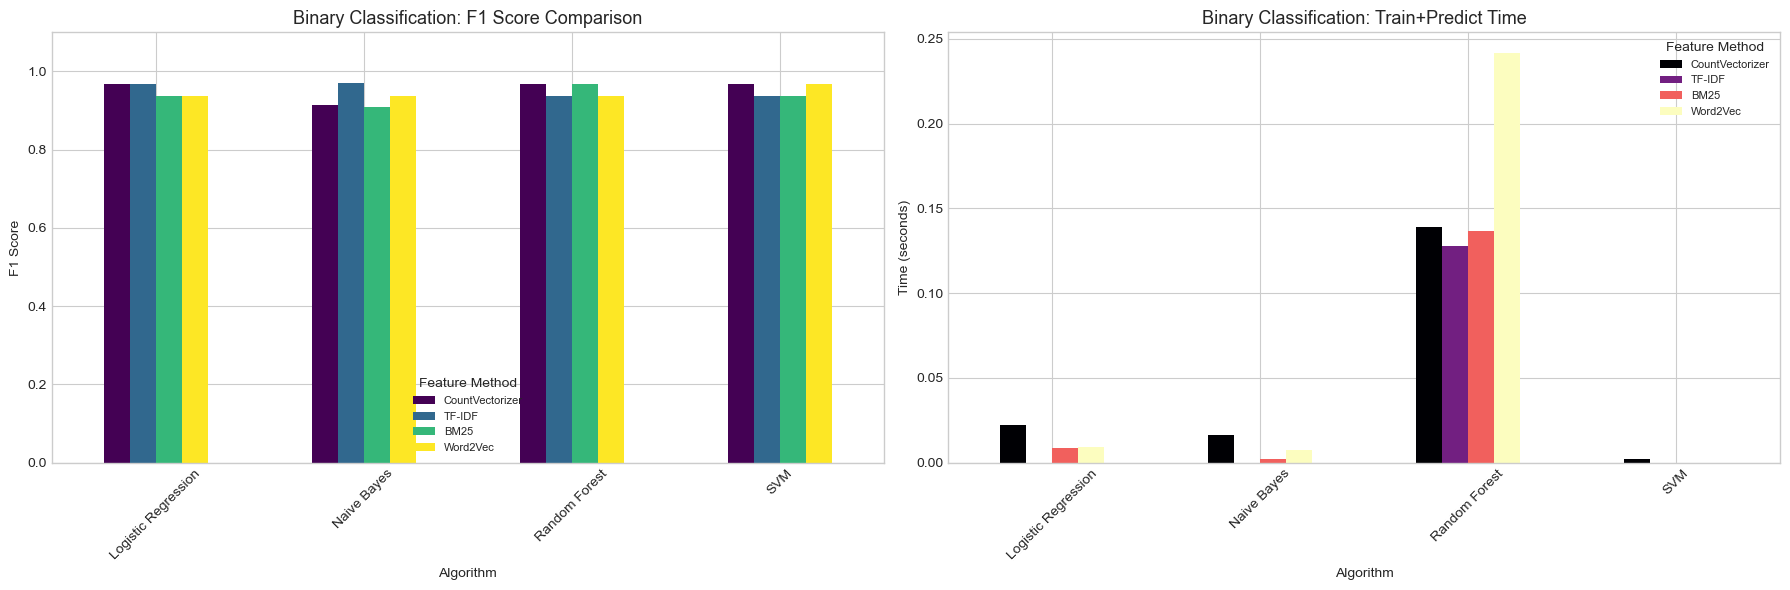

In [25]:
# Visualization: F1 Scores and Timing
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1 Score comparison
binary_pivot.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Binary Classification: F1 Score Comparison', fontsize=13)
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('F1 Score')
axes[0].legend(title='Feature Method', fontsize=8)
axes[0].set_ylim(0, 1.1)
axes[0].tick_params(axis='x', rotation=45)

# Timing comparison
binary_time_pivot.plot(kind='bar', ax=axes[1], colormap='magma')
axes[1].set_title('Binary Classification: Train+Predict Time', fontsize=13)
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('Time (seconds)')
axes[1].legend(title='Feature Method', fontsize=8)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 6.2 Multiclass Classification: BBC News Categorization

**Task**: Classify news articles into one of 5 categories: business, entertainment, politics, sport, tech

**Dataset**: BBC News articles with category labels

In [26]:
# =============================================================================
# LOAD AND PREPARE BBC NEWS DATA
# =============================================================================

# Load dataset
bbc_df = pd.read_csv('Data/bbc-news-data.csv', sep='\t')

print("=" * 60)
print("BBC NEWS DATASET")
print("=" * 60)
print(f"Shape: {bbc_df.shape}")
print(f"\nClass distribution:")
print(bbc_df['category'].value_counts())

# Combine title and content
bbc_df['text'] = bbc_df['title'] + ' ' + bbc_df['content']

# Apply preprocessing
bbc_df['text_clean'] = bbc_df['text'].apply(full_preprocess)

# Train-test split
X_train_bbc, X_test_bbc, y_train_bbc, y_test_bbc = train_test_split(
    bbc_df['text_clean'],
    bbc_df['category'],
    test_size=0.2,
    random_state=42,
    stratify=bbc_df['category']
)

print(f"\nTraining samples: {len(X_train_bbc)}")
print(f"Test samples: {len(X_test_bbc)}")

BBC NEWS DATASET
Shape: (2225, 4)

Class distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Training samples: 1780
Test samples: 445


In [27]:
# =============================================================================
# MULTICLASS: ALL FEATURE METHODS
# =============================================================================

multiclass_all_results = []

# --- CountVectorizer ---
print("\n" + "=" * 60)
print("FEATURE: CountVectorizer")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_count_features(X_train_bbc, X_test_bbc)

for name, clf in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                   ('SVM', LinearSVC(random_state=42, max_iter=2000)),
                   ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_bbc)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multiclass(y_test_bbc, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'CountVectorizer'
    multiclass_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    print(classification_report(y_test_bbc, y_pred))


# --- TF-IDF ---
print("\n" + "=" * 60)
print("FEATURE: TF-IDF")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_tfidf_features(X_train_bbc, X_test_bbc)

for name, clf in [('Naive Bayes', MultinomialNB()),
                   ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                   ('SVM', LinearSVC(random_state=42, max_iter=2000)),
                   ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_bbc)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multiclass(y_test_bbc, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'TF-IDF'
    multiclass_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    print(classification_report(y_test_bbc, y_pred))

# --- BM25 ---
print("\n" + "=" * 60)
print("FEATURE: BM25")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_bm25_features(X_train_bbc, X_test_bbc)

for name, clf in [('Naive Bayes', GaussianNB()),
                   ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                   ('SVM', SVC(kernel='linear', random_state=42)),
                   ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_bbc)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multiclass(y_test_bbc, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'BM25'
    multiclass_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    print(classification_report(y_test_bbc, y_pred))


# --- Word2Vec ---
print("\n" + "=" * 60)
print("FEATURE: Word2Vec")
print("=" * 60)
X_train_feat, X_test_feat = create_word2vec_features(X_train_bbc, X_test_bbc)

for name, clf in [('Naive Bayes', GaussianNB()),
                   ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
                   ('SVM', SVC(kernel='linear', random_state=42)),
                   ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_bbc)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multiclass(y_test_bbc, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'Word2Vec'
    multiclass_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    print(classification_report(y_test_bbc, y_pred))




FEATURE: CountVectorizer
CountVectorizer:
  Vocabulary size: 5000
  Train shape: (1780, 5000)
  Test shape: (445, 5000)
  Naive Bayes: F1 = 0.9840 | Time: 0.0067s
               precision    recall  f1-score   support

     business       0.99      0.96      0.98       102
entertainment       0.99      1.00      0.99        77
     politics       0.98      0.98      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.96      0.99      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445

  Logistic Regression: F1 = 0.9804 | Time: 7.3563s
               precision    recall  f1-score   support

     business       0.95      0.97      0.96       102
entertainment       0.99      1.00      0.99        77
     politics       0.99      0.95      0.97        84
        sport       0.98      1.00      0.99       102
         te

In [28]:
# =============================================================================
# MULTICLASS CLASSIFICATION SUMMARY
# =============================================================================

multiclass_df = pd.DataFrame(multiclass_all_results)

print("\n" + "=" * 70)
print("MULTICLASS CLASSIFICATION: COMPLETE RESULTS")
print("=" * 70)

# Pivot table: F1 Scores
feature_cols = [c for c in ['CountVectorizer', 'TF-IDF', 'BM25', 'Word2Vec', 'Sentence-BERT'] 
                if c in multiclass_df['Feature'].unique()]
multiclass_pivot = multiclass_df.pivot(index='Algorithm', columns='Feature', values='F1')
multiclass_pivot = multiclass_pivot[feature_cols]

print("\nF1 Scores (macro) by Algorithm and Feature Method:")
display(multiclass_pivot.style.format('{:.2%}').background_gradient(cmap='YlGn', axis=None))

# Pivot table: Training Time
multiclass_time_pivot = multiclass_df.pivot(index='Algorithm', columns='Feature', values='Train+Predict (s)')
multiclass_time_pivot = multiclass_time_pivot[feature_cols]

print("\n⏱ Train+Predict Time (seconds):")
display(multiclass_time_pivot.style.format('{:.4f}').background_gradient(cmap='YlOrRd', axis=None))

# Best combination
best_idx = multiclass_df['F1'].idxmax()
best = multiclass_df.loc[best_idx]
print(f"\n✓ Best combination: {best['Feature']} + {best['Algorithm']} (F1: {best['F1']:.2%})")

# Fastest
fastest_idx = multiclass_df['Train+Predict (s)'].idxmin()
fastest = multiclass_df.loc[fastest_idx]
print(f"⚡ Fastest combination: {fastest['Feature']} + {fastest['Algorithm']} ({fastest['Train+Predict (s)']:.4f}s)")





MULTICLASS CLASSIFICATION: COMPLETE RESULTS

F1 Scores (macro) by Algorithm and Feature Method:


Feature,CountVectorizer,TF-IDF,BM25,Word2Vec
Algorithm,,,,
Logistic Regression,98.04%,99.12%,98.44%,95.92%
Naive Bayes,98.40%,98.40%,88.62%,93.08%
Random Forest,96.22%,96.65%,95.08%,95.93%
SVM,98.21%,98.89%,98.66%,96.33%



⏱ Train+Predict Time (seconds):


Feature,CountVectorizer,TF-IDF,BM25,Word2Vec
Algorithm,,,,
Logistic Regression,7.3563,0.1332,0.2028,0.0601
Naive Bayes,0.0067,0.0074,0.0910,0.0000
Random Forest,0.2810,0.2666,0.7873,0.3669
SVM,0.6737,0.0333,1.2433,0.0670



✓ Best combination: TF-IDF + Logistic Regression (F1: 99.12%)
⚡ Fastest combination: Word2Vec + Naive Bayes (0.0000s)


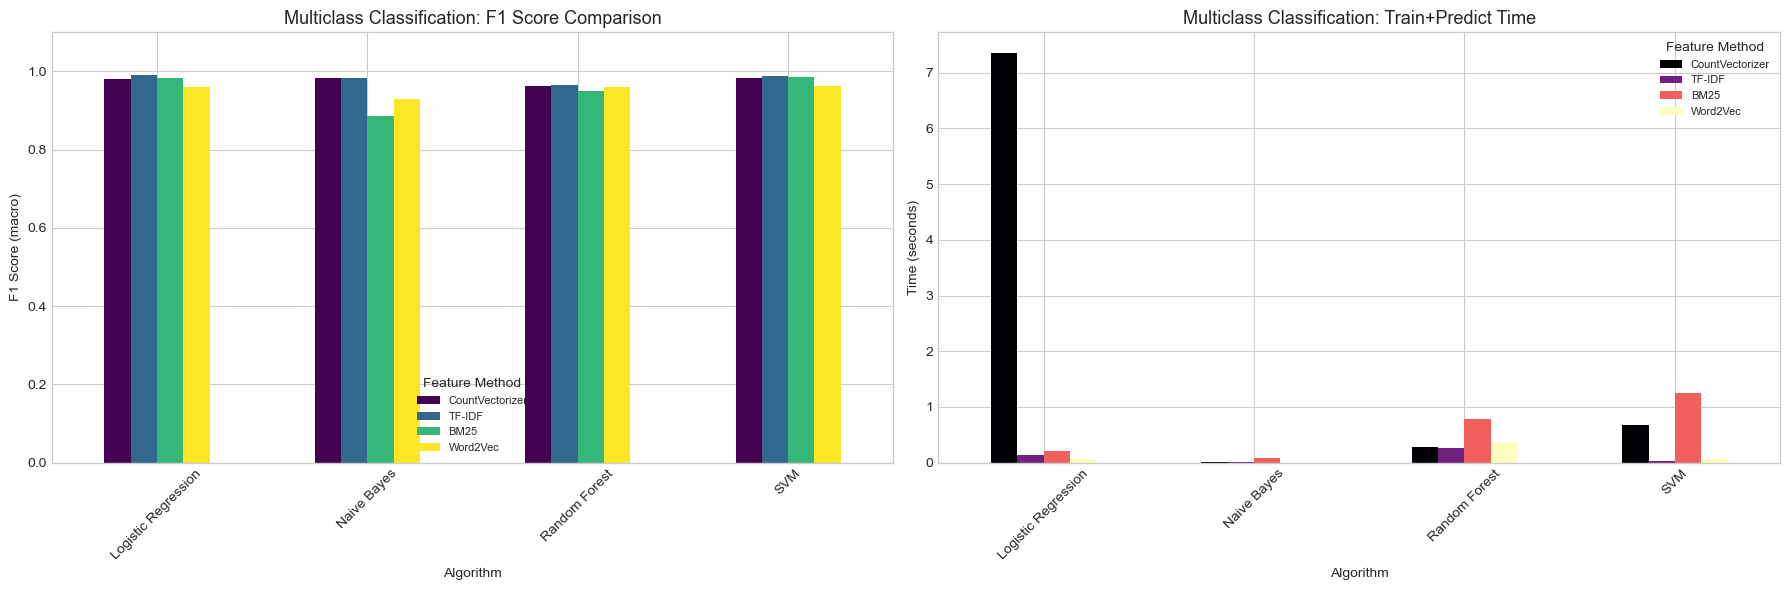

In [29]:
# Visualization: F1 Scores and Timing
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1 Score comparison
multiclass_pivot.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Multiclass Classification: F1 Score Comparison', fontsize=13)
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('F1 Score (macro)')
axes[0].legend(title='Feature Method', fontsize=8)
axes[0].set_ylim(0, 1.1)
axes[0].tick_params(axis='x', rotation=45)

# Timing comparison
multiclass_time_pivot.plot(kind='bar', ax=axes[1], colormap='magma')
axes[1].set_title('Multiclass Classification: Train+Predict Time', fontsize=13)
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('Time (seconds)')
axes[1].legend(title='Feature Method', fontsize=8)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 6.3 Multilabel Classification: Toxic Comment Detection

**Task**: Identify multiple types of toxicity in comments (a comment can have multiple labels)

**Labels**: toxic, severe_toxic, obscene, threat, insult, identity_hate

In [30]:
# =============================================================================
# LOAD AND PREPARE TOXIC COMMENTS DATA
# =============================================================================

# Load dataset
toxic_df = pd.read_csv('Data/toxic_comments_1k.csv')

# Define label columns
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Drop unlabeled rows and convert labels to int
toxic_df = toxic_df.dropna(subset=label_columns)
toxic_df[label_columns] = toxic_df[label_columns].astype(int)

print("=" * 60)
print("TOXIC COMMENTS DATASET")
print("=" * 60)
print(f"Shape: {toxic_df.shape}")
print(f"\nLabel distribution:")
print(toxic_df[label_columns].sum())

# Apply preprocessing
toxic_df['text_clean'] = toxic_df['comment_text'].apply(full_preprocess)


# Train-test split
X_train_toxic, X_test_toxic, y_train_toxic, y_test_toxic = train_test_split(
    toxic_df['text_clean'],
    toxic_df[label_columns].values,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {len(X_train_toxic)}")
print(f"Test samples: {len(X_test_toxic)}")

TOXIC COMMENTS DATASET
Shape: (9999, 8)

Label distribution:
toxic            971
severe_toxic     101
obscene          527
threat            33
insult           494
identity_hate     84
dtype: int64
Training samples: 7999
Test samples: 2000


In [31]:
# =============================================================================
# MULTILABEL: ALL FEATURE METHODS
# =============================================================================

multilabel_all_results = []

# --- CountVectorizer ---
print("\n" + "=" * 60)
print("FEATURE: CountVectorizer")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_count_features(X_train_toxic, X_test_toxic)

for name, clf in [('Naive Bayes', OneVsRestClassifier(MultinomialNB())),
                   ('Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
                   ('SVM', OneVsRestClassifier(LinearSVC(random_state=42, max_iter=2000))),
                   ('Random Forest', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_toxic)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multilabel(y_test_toxic, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'CountVectorizer'
    multilabel_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    hamming = 1 - hamming_loss(y_test_toxic, y_pred)
    jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
    exact   = accuracy_score(y_test_toxic, y_pred)

    print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
    print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
    print(f"Exact Match:      {exact:.4f}  (all labels must match)")
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(classification_report(y_test_toxic, y_pred, target_names=label_columns))

# --- TF-IDF ---
print("\n" + "=" * 60)
print("FEATURE: TF-IDF")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_tfidf_features(X_train_toxic, X_test_toxic)

for name, clf in [('Naive Bayes', OneVsRestClassifier(MultinomialNB())),
                   ('Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
                   ('SVM', OneVsRestClassifier(LinearSVC(random_state=42, max_iter=2000))),
                   ('Random Forest', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_toxic)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multilabel(y_test_toxic, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'TF-IDF'
    multilabel_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    hamming = 1 - hamming_loss(y_test_toxic, y_pred)
    jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
    exact   = accuracy_score(y_test_toxic, y_pred)

    print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
    print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
    print(f"Exact Match:      {exact:.4f}  (all labels must match)")
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(classification_report(y_test_toxic, y_pred, target_names=label_columns))

# --- BM25 --- takes toolong - 1 hour + so I skip it, but you are welcome to run it. SVC(kernel='linear') with dense BM25 features on 10K rows × 6 labels is expensive
"""
print("\n" + "=" * 60)
print("FEATURE: BM25")
print("=" * 60)
X_train_feat, X_test_feat, _ = create_bm25_features(X_train_toxic, X_test_toxic)

for name, clf in [('Naive Bayes', OneVsRestClassifier(GaussianNB())),
                   ('Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
                   ('SVM', OneVsRestClassifier(SVC(kernel='linear', random_state=42))),
                   ('Random Forest', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_toxic)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multilabel(y_test_toxic, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'BM25'
    multilabel_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    hamming = 1 - hamming_loss(y_test_toxic, y_pred)
    jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
    exact   = accuracy_score(y_test_toxic, y_pred)

    print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
    print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
    print(f"Exact Match:      {exact:.4f}  (all labels must match)")
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(classification_report(y_test_toxic, y_pred, target_names=label_columns))
"""

# --- Word2Vec ---
print("\n" + "=" * 60)
print("FEATURE: Word2Vec")
print("=" * 60)
X_train_feat, X_test_feat = create_word2vec_features(X_train_toxic, X_test_toxic)

for name, clf in [('Naive Bayes', OneVsRestClassifier(GaussianNB())),
                   ('Logistic Regression', OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))),
                   ('SVM', OneVsRestClassifier(SVC(kernel='linear', random_state=42))),
                   ('Random Forest', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)))]:
    start_time = time.time()
    clf.fit(X_train_feat, y_train_toxic)
    y_pred = clf.predict(X_test_feat)
    elapsed = time.time() - start_time
    metrics = evaluate_multilabel(y_test_toxic, y_pred)
    metrics['Train+Predict (s)'] = round(elapsed, 4)
    metrics['Algorithm'] = name
    metrics['Feature'] = 'Word2Vec'
    multilabel_all_results.append(metrics)
    print(f"  {name}: F1 = {metrics['F1']:.4f} | Time: {elapsed:.4f}s")
    hamming = 1 - hamming_loss(y_test_toxic, y_pred)
    jaccard = jaccard_score(y_test_toxic, y_pred, average='samples')
    exact   = accuracy_score(y_test_toxic, y_pred)

    print(f"Hamming Score:    {hamming:.4f}  (per-label accuracy)")
    print(f"Jaccard Score:    {jaccard:.4f}  (set overlap / IoU)")
    print(f"Exact Match:      {exact:.4f}  (all labels must match)")
    label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    print(classification_report(y_test_toxic, y_pred, target_names=label_columns))




FEATURE: CountVectorizer
CountVectorizer:
  Vocabulary size: 5000
  Train shape: (7999, 5000)
  Test shape: (2000, 5000)
  Naive Bayes: F1 = 0.6226 | Time: 0.0499s
Hamming Score:    0.9791  (per-label accuracy)
Jaccard Score:    0.0332  (set overlap / IoU)
Exact Match:      0.9175  (all labels must match)
               precision    recall  f1-score   support

        toxic       0.90      0.50      0.64       186
 severe_toxic       0.42      0.38      0.40        21
      obscene       0.86      0.61      0.72        93
       threat       0.00      0.00      0.00         6
       insult       0.77      0.54      0.64        87
identity_hate       0.29      0.15      0.20        13

    micro avg       0.80      0.51      0.62       406
    macro avg       0.54      0.36      0.43       406
 weighted avg       0.81      0.51      0.62       406
  samples avg       0.04      0.04      0.04       406

  Logistic Regression: F1 = 0.5787 | Time: 0.6488s
Hamming Score:    0.9779  (per-la

In [32]:
# =============================================================================
# MULTILABEL CLASSIFICATION SUMMARY
# =============================================================================

multilabel_df = pd.DataFrame(multilabel_all_results)

print("\n" + "=" * 70)
print("MULTILABEL CLASSIFICATION: COMPLETE RESULTS")
print("=" * 70)

# Pivot table: F1 Scores
feature_cols_ml = [c for c in ['CountVectorizer', 'TF-IDF', 'Word2Vec'] 
                   if c in multilabel_df['Feature'].unique()]
multilabel_pivot = multilabel_df.pivot(index='Algorithm', columns='Feature', values='F1')
multilabel_pivot = multilabel_pivot[feature_cols_ml]

print("\nF1 Scores (micro) by Algorithm and Feature Method:")
display(multilabel_pivot.style.format('{:.2%}').background_gradient(cmap='YlGn', axis=None))

# Pivot table: Training Time
multilabel_time_pivot = multilabel_df.pivot(index='Algorithm', columns='Feature', values='Train+Predict (s)')
multilabel_time_pivot = multilabel_time_pivot[feature_cols_ml]

print("\n⏱ Train+Predict Time (seconds):")
display(multilabel_time_pivot.style.format('{:.4f}').background_gradient(cmap='YlOrRd', axis=None))

# Best combination
best_idx = multilabel_df['F1'].idxmax()
best = multilabel_df.loc[best_idx]
print(f"\n✓ Best combination: {best['Feature']} + {best['Algorithm']} (F1: {best['F1']:.2%})")

# Fastest
fastest_idx = multilabel_df['Train+Predict (s)'].idxmin()
fastest = multilabel_df.loc[fastest_idx]
print(f"⚡ Fastest combination: {fastest['Feature']} + {fastest['Algorithm']} ({fastest['Train+Predict (s)']:.4f}s)")



MULTILABEL CLASSIFICATION: COMPLETE RESULTS

F1 Scores (micro) by Algorithm and Feature Method:


Feature,CountVectorizer,TF-IDF,Word2Vec
Algorithm,,,
Logistic Regression,57.87%,47.51%,54.58%
Naive Bayes,62.26%,34.22%,26.43%
Random Forest,63.69%,62.38%,40.77%
SVM,60.74%,63.00%,51.03%



⏱ Train+Predict Time (seconds):


Feature,CountVectorizer,TF-IDF,Word2Vec
Algorithm,,,
Logistic Regression,0.6488,0.2004,0.2880
Naive Bayes,0.0499,0.0329,0.3041
Random Forest,2.6067,3.2316,8.4697
SVM,11.2307,0.1379,6.5928



✓ Best combination: CountVectorizer + Random Forest (F1: 63.69%)
⚡ Fastest combination: TF-IDF + Naive Bayes (0.0329s)


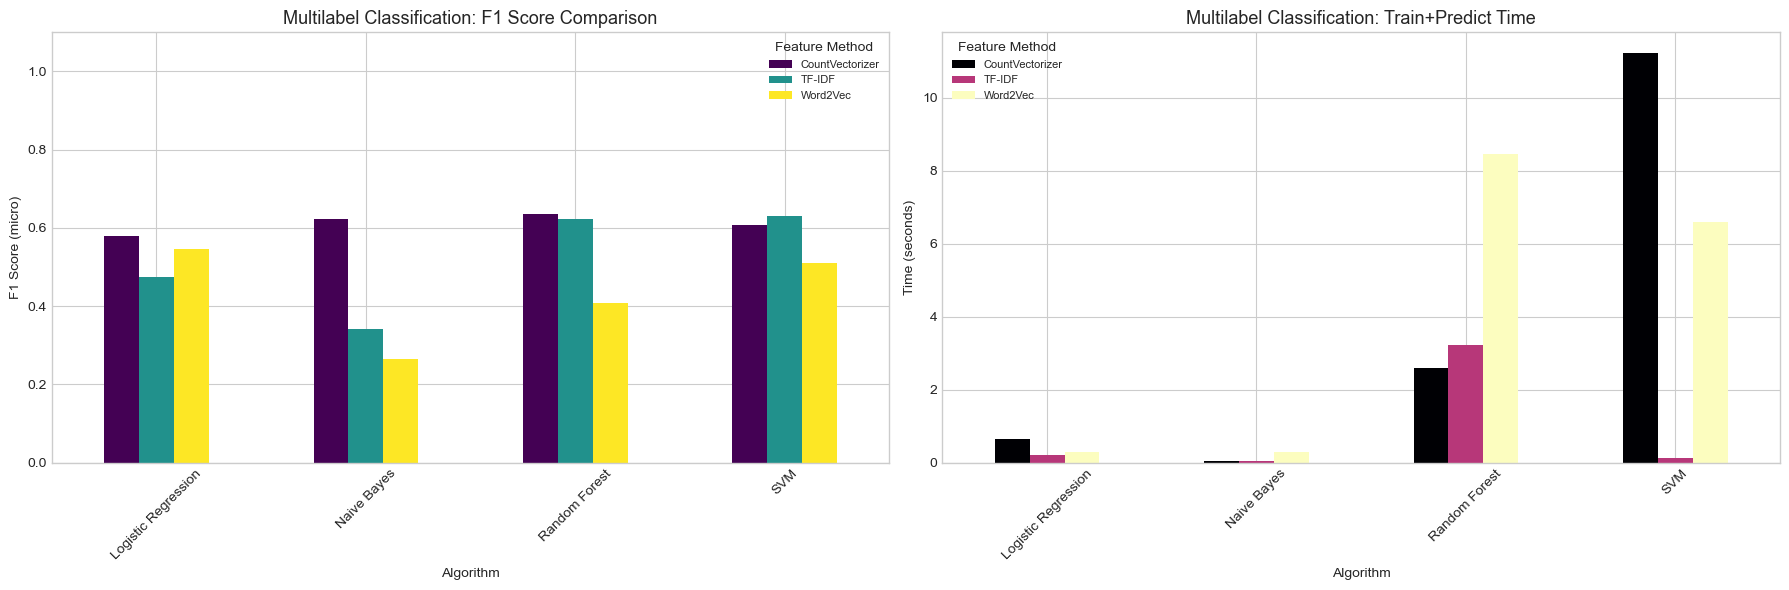

In [33]:
# Visualization: F1 Scores and Timing
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1 Score comparison
multilabel_pivot.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Multilabel Classification: F1 Score Comparison', fontsize=13)
axes[0].set_xlabel('Algorithm')
axes[0].set_ylabel('F1 Score (micro)')
axes[0].legend(title='Feature Method', fontsize=8)
axes[0].set_ylim(0, 1.1)
axes[0].tick_params(axis='x', rotation=45)

# Timing comparison
multilabel_time_pivot.plot(kind='bar', ax=axes[1], colormap='magma')
axes[1].set_title('Multilabel Classification: Train+Predict Time', fontsize=13)
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('Time (seconds)')
axes[1].legend(title='Feature Method', fontsize=8)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


---

<a id='summary'></a>
## 7. Grand Summary: All Results Combined

In [34]:
# =============================================================================
# COMBINE ALL RESULTS
# =============================================================================

# Add task labels
binary_all_results['Task'] = 'Binary'
multiclass_df['Task'] = 'Multiclass'
multilabel_df['Task'] = 'Multilabel'

# Combine
all_results = pd.concat([binary_all_results, multiclass_df, multilabel_df], ignore_index=True)

print("=" * 80)
print("GRAND SUMMARY: ALL TASKS, ALL FEATURES, ALL ALGORITHMS")
print("=" * 80)

GRAND SUMMARY: ALL TASKS, ALL FEATURES, ALL ALGORITHMS


In [45]:
# =============================================================================
# FEATURE METHOD COMPARISON
# =============================================================================

print("\n" + "-" * 70)
print("FEATURE METHOD PERFORMANCE (Average F1 across all algorithms)")
print("-" * 70)

feature_comparison = all_results.pivot_table(
    index='Feature',
    columns='Task',
    values='F1',
    aggfunc='mean'
)
feature_comparison['Average'] = feature_comparison.mean(axis=1)
feature_comparison = feature_comparison.sort_values('Average', ascending=False)
feature_comparison = feature_comparison[['Binary', 'Multiclass', 'Multilabel', 'Average']]

display(feature_comparison.style.format('{:.2%}').background_gradient(cmap='YlGn', axis=None))



----------------------------------------------------------------------
FEATURE METHOD PERFORMANCE (Average F1 across all algorithms)
----------------------------------------------------------------------


Task,Binary,Multiclass,Multilabel,Average
Feature,,,,
BM25,93.80%,95.20%,nan%,94.50%
CountVectorizer,95.44%,97.72%,61.14%,84.76%
TF-IDF,95.31%,98.27%,51.78%,81.78%
Word2Vec,94.51%,95.31%,43.20%,77.67%


In [36]:
# =============================================================================
# ALGORITHM COMPARISON (F1 + Speed)
# =============================================================================

print("\n" + "-" * 70)
print("ALGORITHM PERFORMANCE (Average F1 across all feature methods)")
print("-" * 70)

algo_comparison = all_results.pivot_table(
    index='Algorithm',
    columns='Task',
    values='F1',
    aggfunc='mean'
)
algo_comparison['Average F1'] = algo_comparison.mean(axis=1)
algo_comparison = algo_comparison.sort_values('Average F1', ascending=False)
algo_comparison = algo_comparison[['Binary', 'Multiclass', 'Multilabel', 'Average F1']]

display(algo_comparison.style.format('{:.2%}').background_gradient(cmap='YlGn', axis=None))

print(f"\n✓ Best overall algorithm: {algo_comparison['Average F1'].idxmax()}")

# Speed comparison
print("\n" + "-" * 70)
print("ALGORITHM SPEED (Average Train+Predict Time in seconds)")
print("-" * 70)

algo_speed = all_results.pivot_table(
    index='Algorithm',
    columns='Task',
    values='Train+Predict (s)',
    aggfunc='mean'
)
algo_speed['Average (s)'] = algo_speed.mean(axis=1)
algo_speed = algo_speed.sort_values('Average (s)', ascending=True)
algo_speed = algo_speed[['Binary', 'Multiclass', 'Multilabel', 'Average (s)']]

display(algo_speed.style.format('{:.4f}').background_gradient(cmap='YlOrRd', axis=None))

print(f"\n⚡ Fastest overall algorithm: {algo_speed['Average (s)'].idxmin()}")
print(f"🐢 Slowest overall algorithm: {algo_speed['Average (s)'].idxmax()}")



----------------------------------------------------------------------
ALGORITHM PERFORMANCE (Average F1 across all feature methods)
----------------------------------------------------------------------


Task,Binary,Multiclass,Multilabel,Average F1
Algorithm,,,,
SVM,95.26%,98.02%,58.26%,83.85%
Random Forest,95.26%,95.97%,55.61%,82.28%
Logistic Regression,95.26%,97.88%,53.32%,82.15%
Naive Bayes,93.26%,94.63%,40.97%,76.29%



✓ Best overall algorithm: SVM

----------------------------------------------------------------------
ALGORITHM SPEED (Average Train+Predict Time in seconds)
----------------------------------------------------------------------


Task,Binary,Multiclass,Multilabel,Average (s)
Algorithm,,,,
Naive Bayes,0.0065,0.0263,0.1290,0.0539
Logistic Regression,0.0099,1.9381,0.3791,0.7757
Random Forest,0.1612,0.4254,4.7693,1.7853
SVM,0.0005,0.5043,5.9871,2.1640



⚡ Fastest overall algorithm: Naive Bayes
🐢 Slowest overall algorithm: SVM


In [37]:
# =============================================================================
# BEST COMBINATIONS PER TASK
# =============================================================================

print("\n" + "-" * 70)
print("BEST FEATURE + ALGORITHM COMBINATION PER TASK")
print("-" * 70)

best_per_task = all_results.loc[all_results.groupby('Task')['F1'].idxmax()]
display(best_per_task[['Task', 'Feature', 'Algorithm', 'F1']].style.format({'F1': '{:.2%}'}))


----------------------------------------------------------------------
BEST FEATURE + ALGORITHM COMBINATION PER TASK
----------------------------------------------------------------------


,Task,Feature,Algorithm,F1
4,Binary,TF-IDF,Naive Bayes,96.97%
21,Multiclass,TF-IDF,Logistic Regression,99.12%
35,Multilabel,CountVectorizer,Random Forest,63.69%


In [38]:
# =============================================================================
# COMPLETE HEATMAP: FEATURE x ALGORITHM (F1 + Speed)
# =============================================================================

print("\n" + "-" * 70)
print("COMPLETE GRID: FEATURE × ALGORITHM (Average F1 across all tasks)")
print("-" * 70)

feature_order = [c for c in ['CountVectorizer', 'TF-IDF', 'BM25', 'Word2Vec', 'Sentence-BERT'] 
                 if c in all_results['Feature'].unique()]

complete_grid = all_results.pivot_table(
    index='Algorithm',
    columns='Feature',
    values='F1',
    aggfunc='mean'
)
complete_grid = complete_grid[feature_order]

display(complete_grid.style.format('{:.2%}').background_gradient(cmap='YlOrRd', axis=None))

# Speed grid
print("\n" + "-" * 70)
print("COMPLETE GRID: FEATURE × ALGORITHM (Average Time in seconds)")
print("-" * 70)

speed_grid = all_results.pivot_table(
    index='Algorithm',
    columns='Feature',
    values='Train+Predict (s)',
    aggfunc='mean'
)
speed_grid = speed_grid[feature_order]

display(speed_grid.style.format('{:.4f}').background_gradient(cmap='YlOrRd', axis=None))



----------------------------------------------------------------------
COMPLETE GRID: FEATURE × ALGORITHM (Average F1 across all tasks)
----------------------------------------------------------------------


Feature,CountVectorizer,TF-IDF,BM25,Word2Vec
Algorithm,,,,
Logistic Regression,84.23%,81.14%,96.09%,81.41%
Naive Bayes,84.03%,76.53%,89.77%,71.08%
Random Forest,85.56%,84.26%,95.93%,76.81%
SVM,85.24%,85.21%,96.20%,81.38%



----------------------------------------------------------------------
COMPLETE GRID: FEATURE × ALGORITHM (Average Time in seconds)
----------------------------------------------------------------------


Feature,CountVectorizer,TF-IDF,BM25,Word2Vec
Algorithm,,,,
Logistic Regression,2.6757,0.1112,0.1057,0.1191
Naive Bayes,0.0244,0.0134,0.0465,0.1038
Random Forest,1.0088,1.2086,0.4619,3.0261
SVM,3.9688,0.0571,0.6217,2.2199


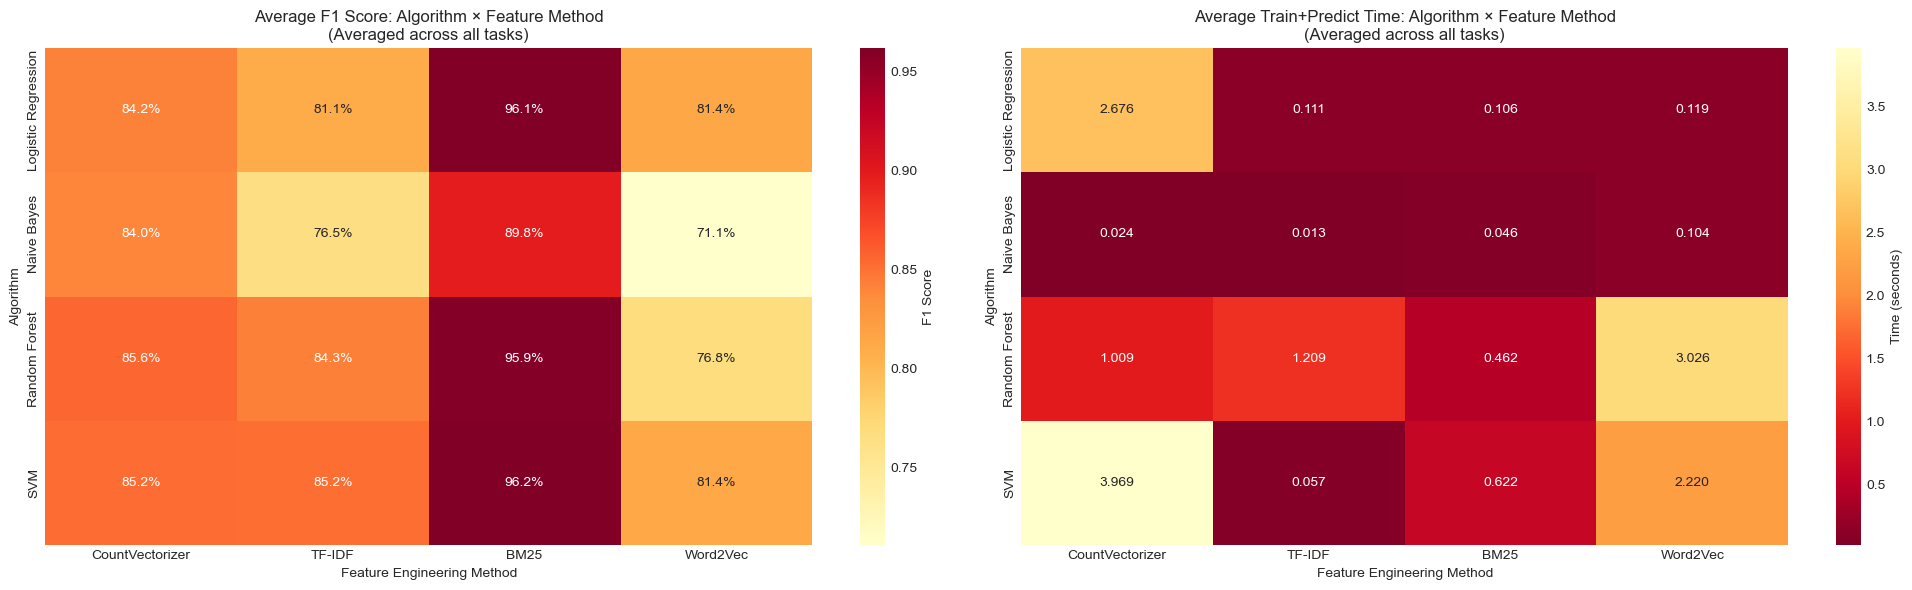

In [39]:
# =============================================================================
# VISUALIZATION: HEATMAPS (F1 + Speed)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# F1 Heatmap
sns.heatmap(complete_grid, annot=True, fmt='.1%', cmap='YlOrRd', ax=axes[0],
            cbar_kws={'label': 'F1 Score'})
axes[0].set_title('Average F1 Score: Algorithm × Feature Method\n(Averaged across all tasks)', fontsize=12)
axes[0].set_xlabel('Feature Engineering Method')
axes[0].set_ylabel('Algorithm')

# Speed Heatmap
sns.heatmap(speed_grid, annot=True, fmt='.3f', cmap='YlOrRd_r', ax=axes[1],
            cbar_kws={'label': 'Time (seconds)'})
axes[1].set_title('Average Train+Predict Time: Algorithm × Feature Method\n(Averaged across all tasks)', fontsize=12)
axes[1].set_xlabel('Feature Engineering Method')
axes[1].set_ylabel('Algorithm')

plt.tight_layout()
plt.show()


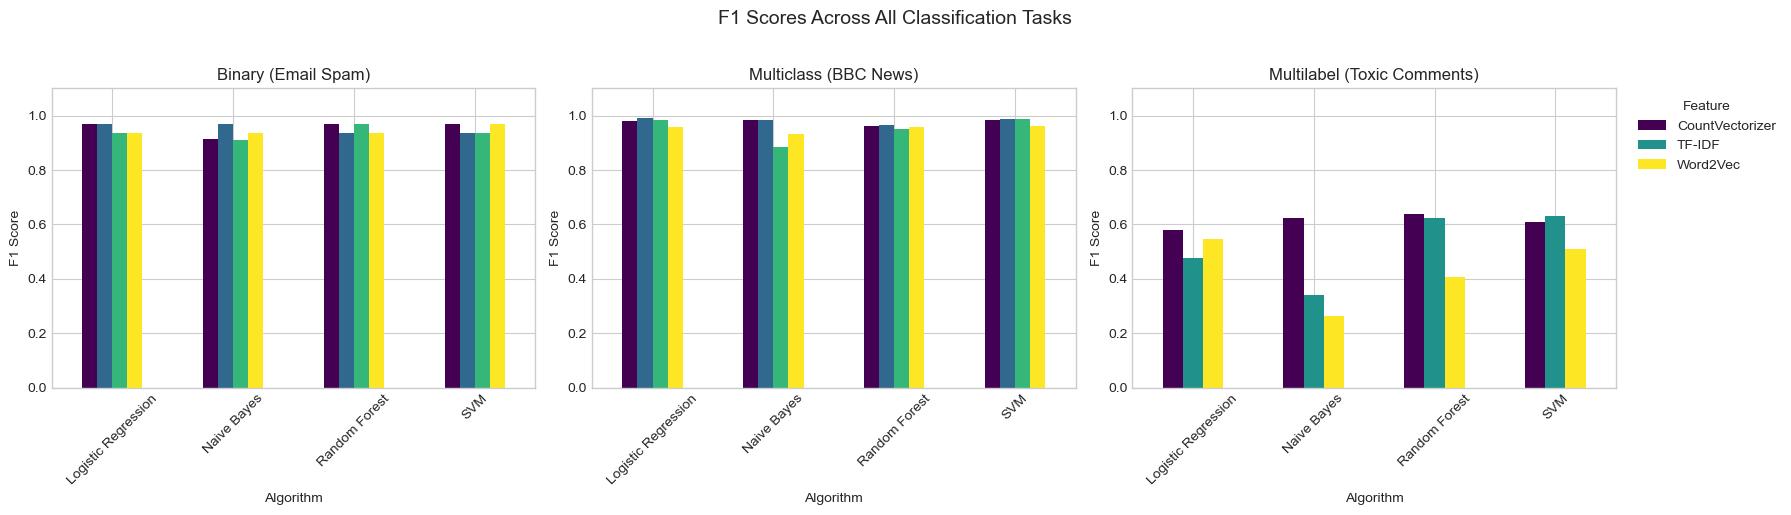

In [40]:
# =============================================================================
# VISUALIZATION: SIDE-BY-SIDE COMPARISON
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pivots = [
    ('Binary (Email Spam)', binary_pivot),
    ('Multiclass (BBC News)', multiclass_pivot),
    ('Multilabel (Toxic Comments)', multilabel_pivot)
]

for idx, (title, pivot) in enumerate(pivots):
    pivot.plot(kind='bar', ax=axes[idx], legend=(idx == 2), colormap='viridis')
    axes[idx].set_title(title, fontsize=12)
    axes[idx].set_ylabel('F1 Score')
    axes[idx].set_ylim(0, 1.1)
    axes[idx].tick_params(axis='x', rotation=45)

axes[2].legend(title='Feature', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.suptitle('F1 Scores Across All Classification Tasks', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

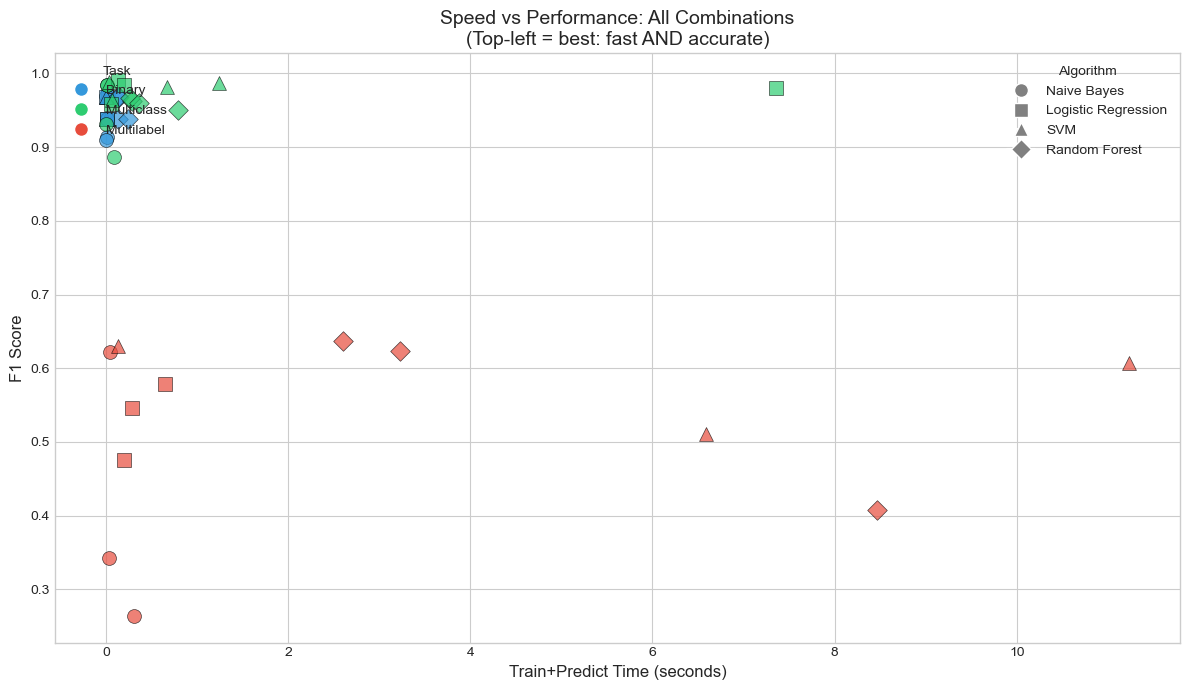

In [41]:
# =============================================================================
# SPEED vs F1 EFFICIENCY SCATTER PLOT
# =============================================================================

fig, ax = plt.subplots(figsize=(12, 7))

# Plot each combination as a point
colors = {'Binary': '#3498db', 'Multiclass': '#2ecc71', 'Multilabel': '#e74c3c'}
markers = {'Naive Bayes': 'o', 'Logistic Regression': 's', 'SVM': '^', 'Random Forest': 'D'}

for _, row in all_results.iterrows():
    ax.scatter(row['Train+Predict (s)'], row['F1'],
              color=colors.get(row['Task'], 'gray'),
              marker=markers.get(row['Algorithm'], 'o'),
              s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

# Legends
from matplotlib.lines import Line2D
task_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10, label=t)
                for t, c in colors.items()]
algo_handles = [Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', markersize=10, label=a)
                for a, m in markers.items()]

legend1 = ax.legend(handles=task_handles, title='Task', loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=algo_handles, title='Algorithm', loc='upper right')

ax.set_xlabel('Train+Predict Time (seconds)', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Speed vs Performance: All Combinations\n(Top-left = best: fast AND accurate)', fontsize=14)

plt.tight_layout()
plt.show()


---

<a id='conclusions'></a>
## 8. Conclusions

### Feature Engineering Insights

| Method | Strengths | Weaknesses | Best Use Case |
|--------|-----------|------------|---------------|
| **CountVectorizer** | Simple, fast, interpretable | No term weighting | Quick baselines |
| **TF-IDF** | Weighs important words, industry standard | High dimensionality | Most text tasks |
| **BM25** | Better term saturation, length normalization | Corpus-size vectors | Information retrieval |
| **Word2Vec** | Captures word semantics | No OOV handling, averaging loses order | Semantic similarity |

### Algorithm Insights

| Algorithm | Strengths | Weaknesses | Best With |
|-----------|-----------|------------|------------|
| **Naive Bayes** | Fast, works with small data | Assumes feature independence | Sparse features |
| **Logistic Regression** | Interpretable, good baseline | Linear decision boundary | Most feature types |
| **SVM** | Effective in high dimensions | Slow on large datasets | Sparse/medium data |
| **Random Forest** | Handles non-linearity | Slower training | Dense embeddings |

### Key Takeaways

1. **TF-IDF** is often the best starting point for text classification
2. **Sentence-BERT** excels when semantic understanding is important
3. **Logistic Regression** and **SVM** are consistently strong classifiers
4. **Feature engineering matters** - the right representation can significantly improve results
5. **No single combination wins all tasks** - always experiment with your specific data